In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import statsmodels.api as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras import Sequential
from keras import layers
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import tensorflow_addons as tfa
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError

from tensorflow.keras.layers import GRU
import xgboost as xgb
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import dot


D:\Users\aneeta\anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
D:\Users\aneeta\anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not fi

In [2]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [3]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
sess = tf.compat.v1.Session(config=config)

In [4]:
df1=pd.read_csv('Daily_Power_Gen_States_march_23.csv')
df1.head(20)

,Region,States,Max.Demand Met during the day(MW),Shortage during maximum Demand(MW),Energy Met (MU),date
0,NER,Mizoram,77,1.0,1.2,01-01-2015
1,WR,DD,214,0.0,4.8,01-01-2015
2,WR,Goa,383,0.0,7.3,01-01-2015
3,WR,Maharashtra,14837,57.0,315.0,01-01-2015
4,WR,MP,5740,0.0,109.8,01-01-2015
5,WR,Gujarat,11383,0.0,246.4,01-01-2015
6,WR,Chhattisgarh,3052,18.0,64.6,01-01-2015
7,WR,DNH,581,0.0,14.0,01-01-2015
8,NR,Chandigarh,224,0.0,3.8,01-01-2015
9,NR,HP,1367,0.0,25.1,01-01-2015


In [5]:
df1.shape

(126699, 6)

In [6]:
dfk=df1.copy()[df1['States']=='Kerala']
dfk.head()

,Region,States,Max.Demand Met during the day(MW),Shortage during maximum Demand(MW),Energy Met (MU),date
31,SR,Kerala,3288,125.0,60.9,01-01-2015
66,SR,Kerala,3010,0.0,56.2,01-01-2016
75,SR,Kerala,3296,0.0,59.7,01-01-2016
137,SR,Kerala,3353,0.0,64.0,01-01-2018
175,SR,Kerala,3501,0.0,68.1,01-01-2019


In [7]:
dfk.shape

(3539, 6)

In [8]:
dfk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3539 entries, 31 to 126694
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Region                              3539 non-null   object 
 1   States                              3539 non-null   object 
 2   Max.Demand Met during the day(MW)   3539 non-null   int64  
 3   Shortage during maximum Demand(MW)  3536 non-null   float64
 4   Energy Met (MU)                     3539 non-null   float64
 5   date                                3539 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 193.5+ KB


In [9]:
dfk.describe().T

,count,mean,std,min,25%,50%,75%,max
Max.Demand Met during the day(MW),3539.0,3403.179429,338.777934,2129.0,3183.0,3391.0,3618.0,4517.0
Shortage during maximum Demand(MW),3536.0,46.436652,113.607090,-150.0,0.0,0.0,0.0,950.0
Energy Met (MU),3539.0,66.968494,8.343733,38.9,61.0,66.1,72.5,93.1


In [10]:
dfk['date'] = pd.to_datetime(dfk['date'],format='%d-%m-%Y')

In [11]:
dfk.isna().sum()

Region                                0
States                                0
Max.Demand Met during the day(MW)     0
Shortage during maximum Demand(MW)    3
Energy Met (MU)                       0
date                                  0
dtype: int64

In [12]:
dfk[dfk.isna().any(axis=1)]

,Region,States,Max.Demand Met during the day(MW),Shortage during maximum Demand(MW),Energy Met (MU),date
8335,SR,Kerala,3477,NaN,65.9,2018-01-03
37649,SR,Kerala,3509,NaN,69.2,2018-02-10
126518,SR,Kerala,3180,NaN,58.7,2017-12-31


In [13]:
dfk.fillna({'Shortage during maximum Demand(MW)': dfk['Shortage during maximum Demand(MW)'].mean()}, inplace=True)
dfk.isna().sum()

Region                                0
States                                0
Max.Demand Met during the day(MW)     0
Shortage during maximum Demand(MW)    0
Energy Met (MU)                       0
date                                  0
dtype: int64

In [14]:
dfk.duplicated().sum()

0

In [15]:
dfk=dfk.drop_duplicates()
dfk.duplicated().sum()

0

In [16]:
dfk=dfk.sort_values(by='date', ascending=True)
dfk.head()

,Region,States,Max.Demand Met during the day(MW),Shortage during maximum Demand(MW),Energy Met (MU),date
124764,SR,Kerala,2736,500.0,56.0,2013-03-31
1130,SR,Kerala,2940,500.0,57.6,2013-04-01
5197,SR,Kerala,3065,500.0,59.5,2013-04-02
9225,SR,Kerala,2935,400.0,62.0,2013-04-03
13230,SR,Kerala,3046,500.0,61.4,2013-04-04


In [17]:
dfw=pd.read_csv("weather.csv")
dfw.head()

,YEAR,MO,DY,Temp,dew point,Humidity,Precipitation,Wind Speed,Pressure
0,2013,3,31,28.61,20.43,15.62,0.03,2.39,96.74
1,2013,4,1,28.62,20.65,15.87,0.00,2.42,96.83
2,2013,4,2,28.59,20.30,15.50,0.04,2.64,96.84
3,2013,4,3,28.90,21.03,16.24,0.06,2.23,96.81
4,2013,4,4,28.81,20.69,15.93,0.03,3.11,96.78


In [18]:
separator = '-'
dfw['date'] = dfw['YEAR'].astype(str) + separator + dfw['MO'].astype(str) + separator + dfw['DY'].astype(str)
cols=['YEAR','MO','DY']
dfw.drop(columns=cols,inplace=True)
dfw.head()

,Temp,dew point,Humidity,Precipitation,Wind Speed,Pressure,date
0,28.61,20.43,15.62,0.03,2.39,96.74,2013-3-31
1,28.62,20.65,15.87,0.00,2.42,96.83,2013-4-1
2,28.59,20.30,15.50,0.04,2.64,96.84,2013-4-2
3,28.90,21.03,16.24,0.06,2.23,96.81,2013-4-3
4,28.81,20.69,15.93,0.03,3.11,96.78,2013-4-4


In [19]:
dfw.shape

(3653, 7)

In [20]:
dfw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temp           3653 non-null   float64
 1   dew point      3653 non-null   float64
 2   Humidity       3653 non-null   float64
 3   Precipitation  3653 non-null   float64
 4   Wind Speed     3653 non-null   float64
 5   Pressure       3653 non-null   float64
 6   date           3653 non-null   object 
dtypes: float64(6), object(1)
memory usage: 199.9+ KB


In [21]:
dfw.describe().T

,count,mean,std,min,25%,50%,75%,max
Temp,3653.0,25.427599,1.778518,21.10,24.14,24.84,26.52,31.32
dew point,3653.0,20.729494,2.870757,6.04,19.56,21.84,22.66,24.68
Humidity,3653.0,16.185379,2.467500,6.47,14.89,17.09,17.94,20.39
Precipitation,3653.0,5.410323,8.402454,0.00,0.09,1.89,7.48,91.75
Wind Speed,3653.0,2.264498,0.744277,0.67,1.73,2.17,2.71,5.54
Pressure,3653.0,96.851944,0.172514,96.08,96.73,96.85,96.97,97.40


In [22]:
dfw.isna().sum()

Temp             0
dew point        0
Humidity         0
Precipitation    0
Wind Speed       0
Pressure         0
date             0
dtype: int64

In [23]:
dfk.duplicated().sum()

0

In [24]:
dfw['date'] = pd.to_datetime(dfw['date'])

In [25]:
df2=pd.merge(dfk,dfw,on="date",how="left")
df2.set_index('date', inplace=True)
dcols=['Region','States','Shortage during maximum Demand(MW)']
df2.drop(columns=dcols,inplace=True)
df2.head()

,Max.Demand Met during the day(MW),Energy Met (MU),Temp,dew point,Humidity,Precipitation,Wind Speed,Pressure
date,,,,,,,,
2013-03-31,2736,56.0,28.61,20.43,15.62,0.03,2.39,96.74
2013-04-01,2940,57.6,28.62,20.65,15.87,0.00,2.42,96.83
2013-04-02,3065,59.5,28.59,20.30,15.50,0.04,2.64,96.84
2013-04-03,2935,62.0,28.90,21.03,16.24,0.06,2.23,96.81
2013-04-04,3046,61.4,28.81,20.69,15.93,0.03,3.11,96.78


In [26]:
df2.shape

(3539, 8)

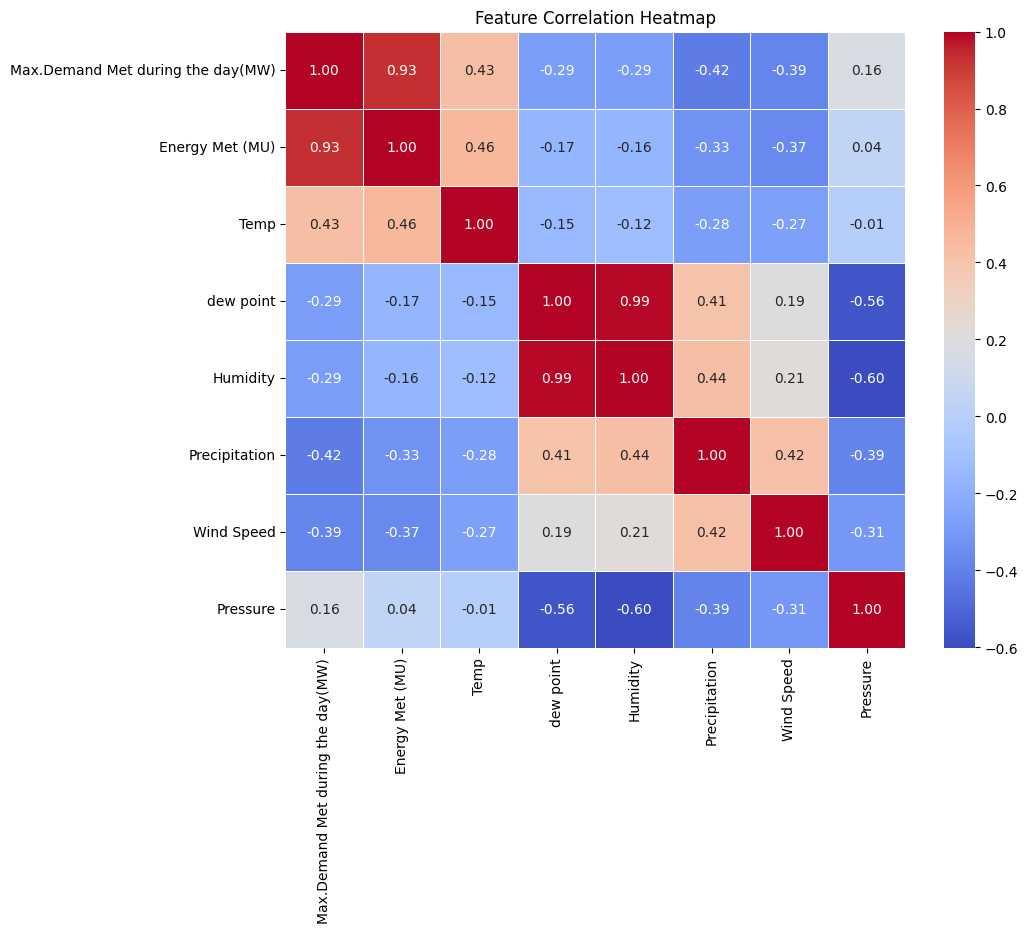

In [27]:
correlation_matrix = df2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [28]:
dcols=['dew point']
df2.drop(columns=dcols,inplace=True)

<Axes: xlabel='Max.Demand Met during the day(MW)', ylabel='Count'>

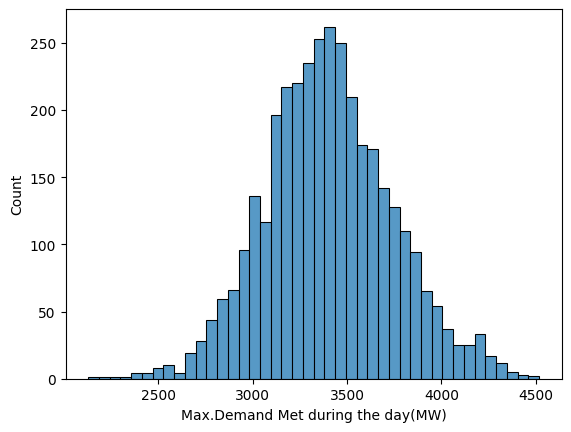

In [29]:
sns.histplot(df2["Max.Demand Met during the day(MW)"])

In [30]:
df2["Max.Demand Met during the day(MW)"].skew()

0.14692041869975198

<Axes: xlabel='date', ylabel='Max.Demand Met during the day(MW)'>

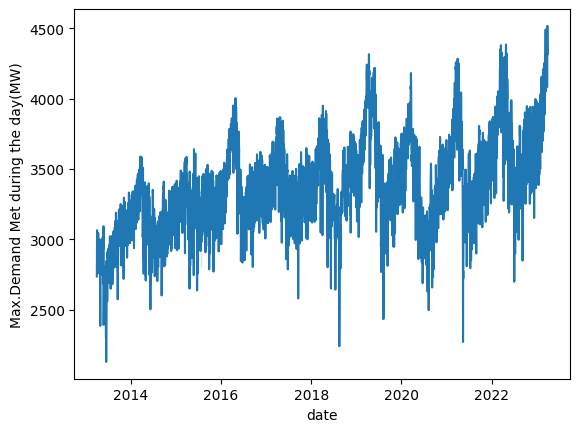

In [31]:
sns.lineplot(data=df2,x=df2.index,y=df2["Max.Demand Met during the day(MW)"])

In [32]:
df2.index = pd.to_datetime(df2.index)
df2['weekday'] = df2.index.weekday
df2['month'] = df2.index.month
df2['year'] = df2.index.year

In [33]:
df2.head()

,Max.Demand Met during the day(MW),Energy Met (MU),Temp,Humidity,Precipitation,Wind Speed,Pressure,weekday,month,year
date,,,,,,,,,,
2013-03-31,2736,56.0,28.61,15.62,0.03,2.39,96.74,6,3,2013
2013-04-01,2940,57.6,28.62,15.87,0.00,2.42,96.83,0,4,2013
2013-04-02,3065,59.5,28.59,15.50,0.04,2.64,96.84,1,4,2013
2013-04-03,2935,62.0,28.90,16.24,0.06,2.23,96.81,2,4,2013
2013-04-04,3046,61.4,28.81,15.93,0.03,3.11,96.78,3,4,2013


Text(0.5, 1.0, 'Daily Demand')

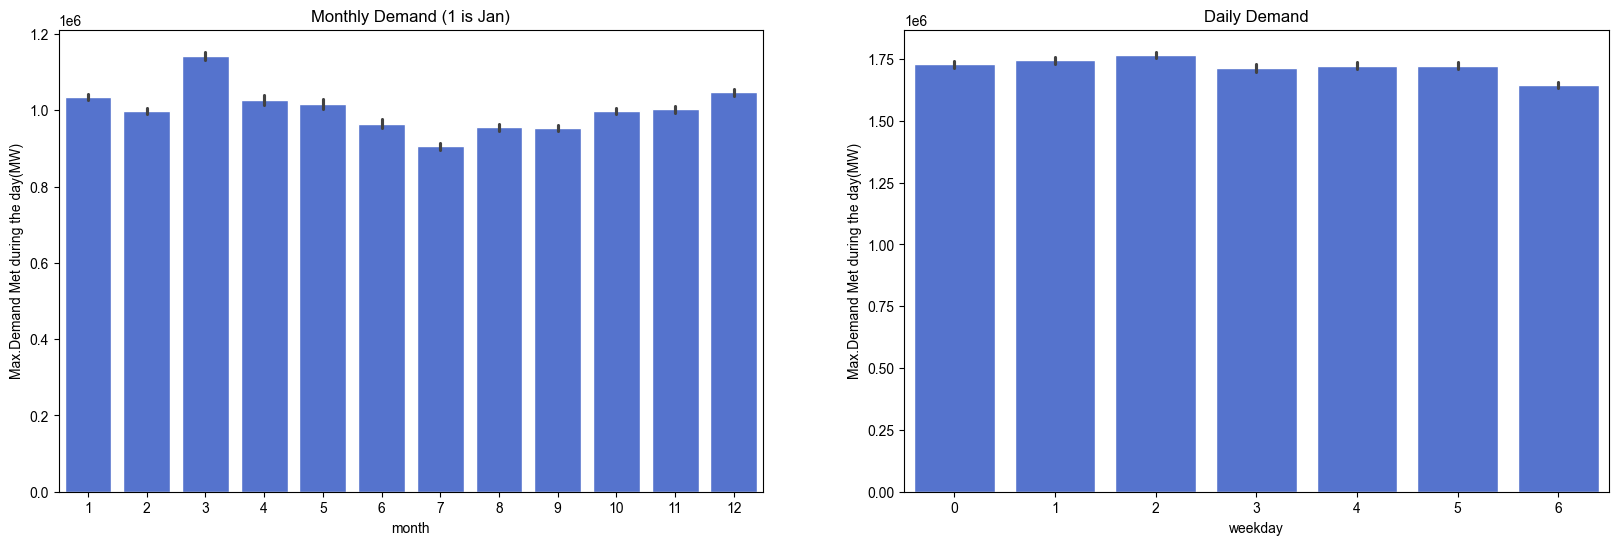

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))
sns.set(style="darkgrid")

sns.barplot(
    x="month",
    y="Max.Demand Met during the day(MW)",
    data=df2,
    estimator=sum,
    color='royalblue',
    ax=axes[0]);
axes[0].set_title('Monthly Demand (1 is Jan)')

sns.barplot(
    x="weekday",
    y="Max.Demand Met during the day(MW)",
    data=df2,
    estimator=sum,
    color='royalblue',
    ax=axes[1]);
axes[1].set_title('Daily Demand')


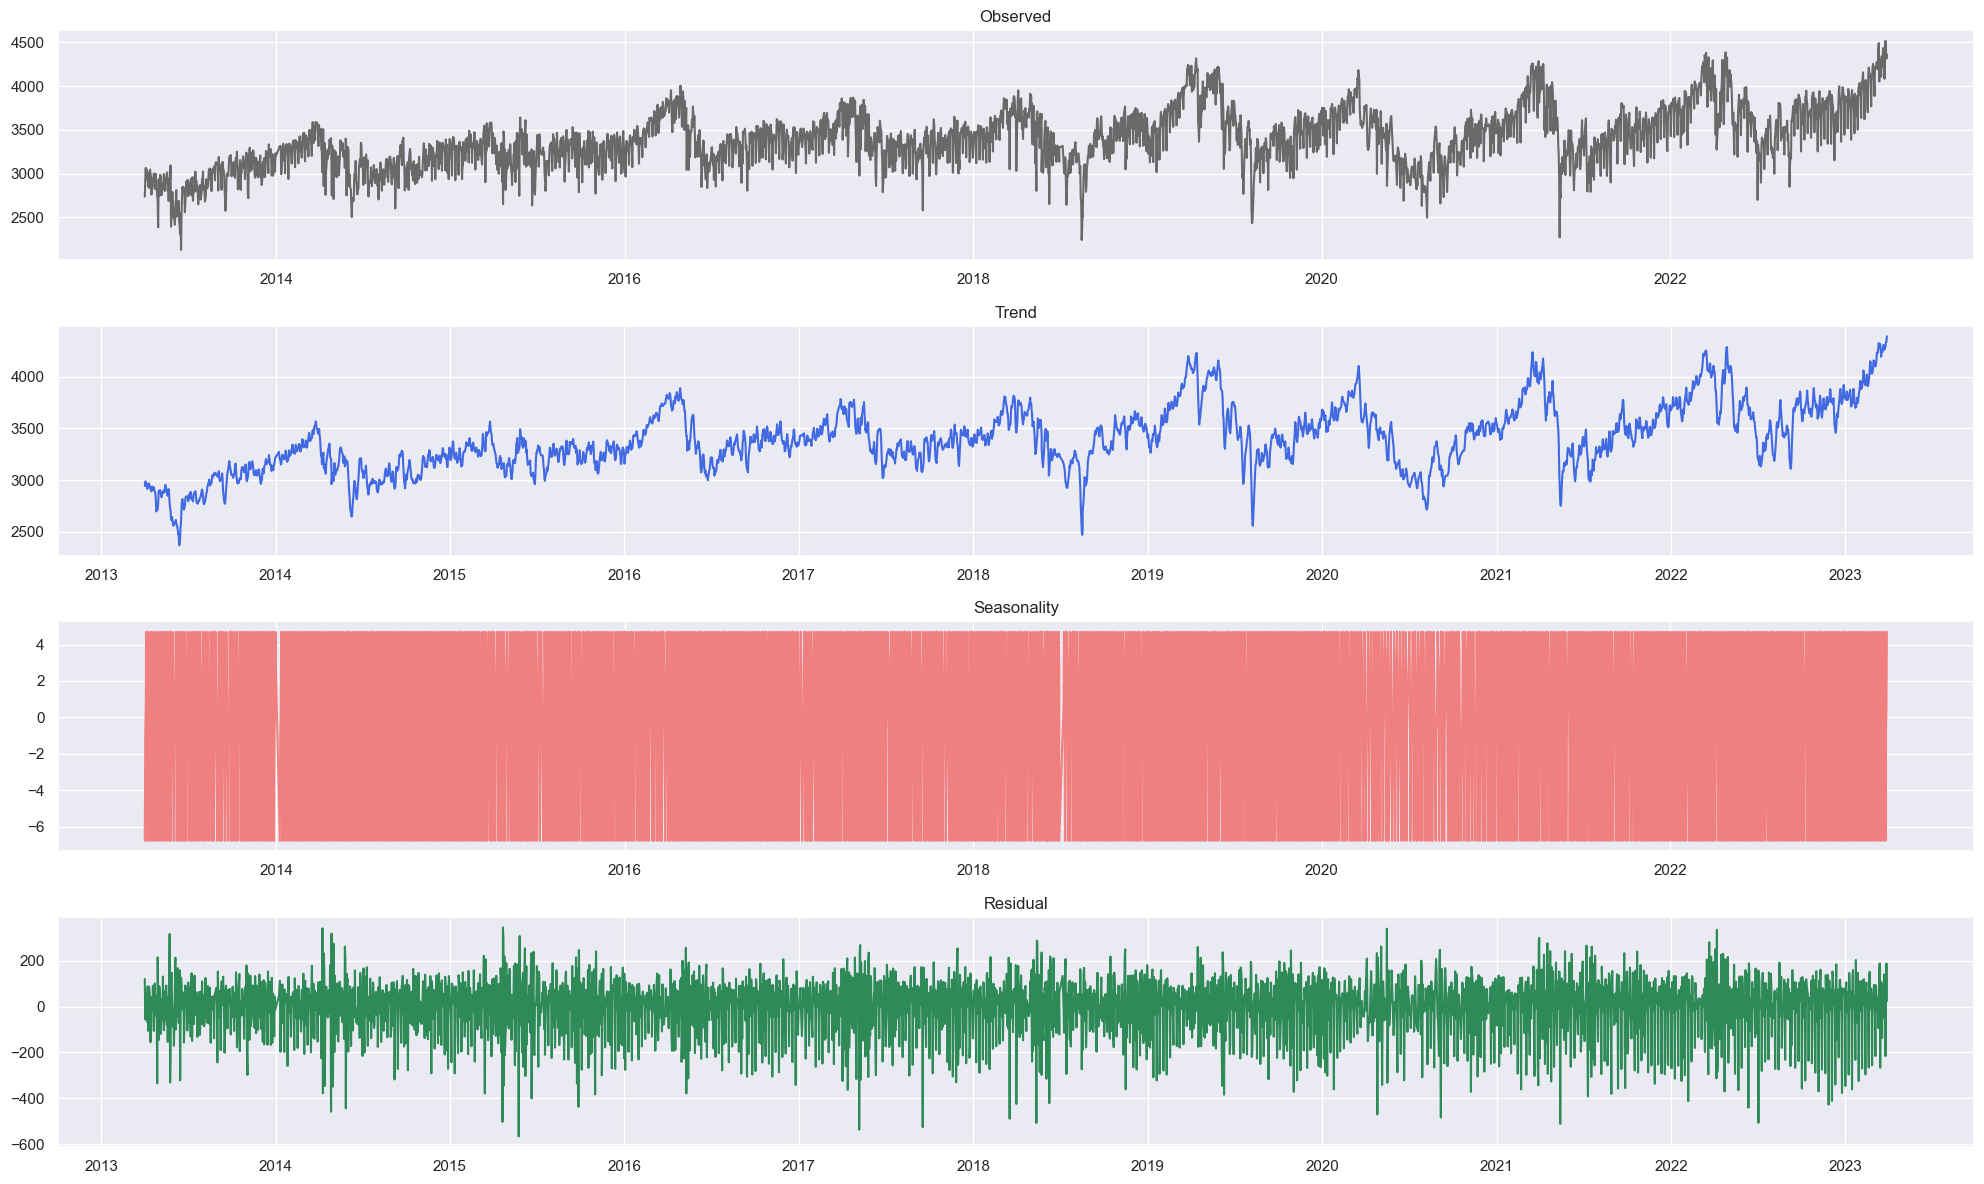

In [35]:
fig, axes = plt.subplots(4, 1, figsize=(20, 12))
decompose_result = seasonal_decompose(df2['Max.Demand Met during the day(MW)'], period =5, model='additive')

observed    = decompose_result.observed
trend    = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

axes[0].plot(observed, color='dimgrey')
axes[0].set_title('Observed')
axes[1].plot(trend, color='royalblue')
axes[1].set_title('Trend')
axes[2].plot(seasonal, color='lightcoral')
axes[2].set_title('Seasonality')
axes[3].plot(residual, color='seagreen')
axes[3].set_title('Residual')

fig.tight_layout()
plt.show()


In [36]:
result = sts.tsa.adfuller(df2['Max.Demand Met during the day(MW)'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")

ADF Statistic: -2.8764913604493048
p-value: 0.048150824198915934
Critical Values:
	1%: -3.4322149444714065
	5%: -2.8623640267493293
	10%: -2.567208643634359


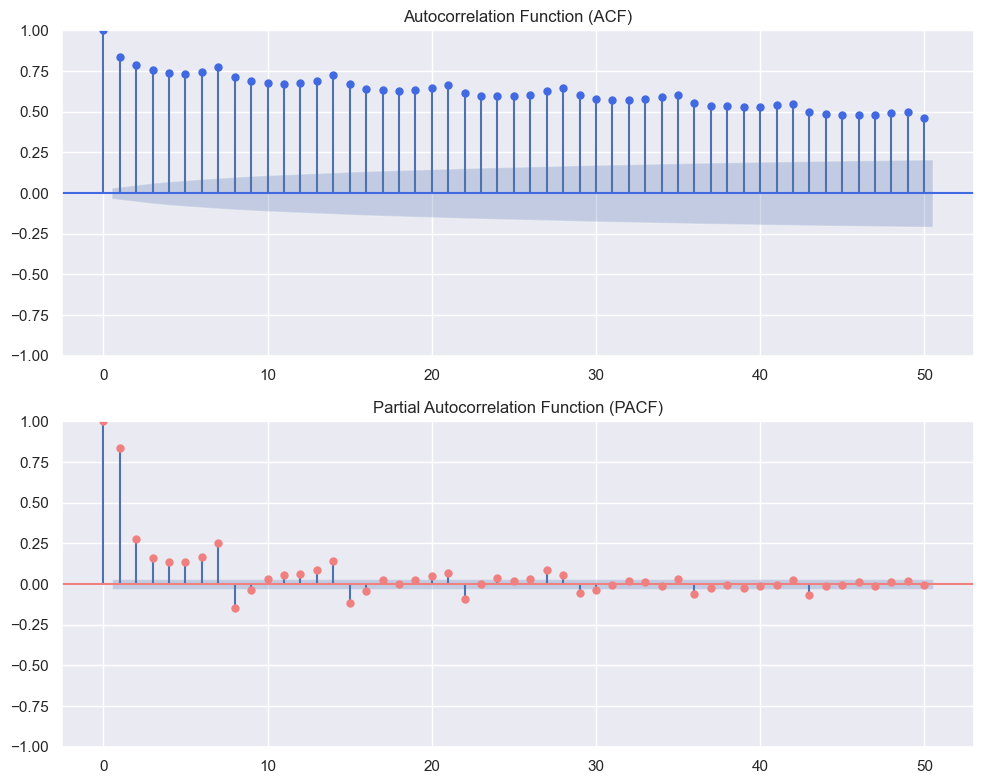

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
sgt.plot_acf(df2['Max.Demand Met during the day(MW)'], ax=ax1, lags=50,color='royalblue')
ax1.set_title('Autocorrelation Function (ACF)')
sgt.plot_pacf(df2['Max.Demand Met during the day(MW)'], ax=ax2, lags=50, color='lightcoral')
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [38]:
df3=df2.copy()

<Axes: xlabel='date'>

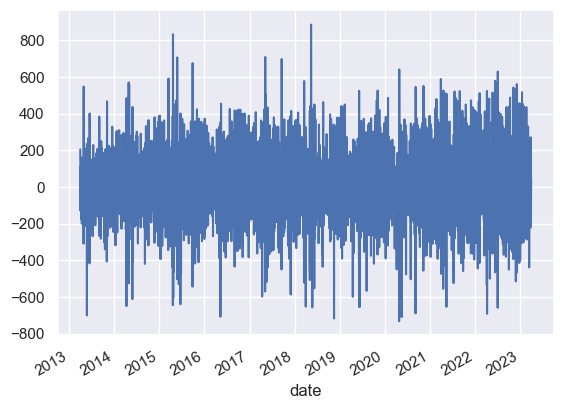

In [39]:
df3['diff']=df3['Max.Demand Met during the day(MW)']-df3['Max.Demand Met during the day(MW)'].shift(1)
df3['diff'].dropna().plot()

In [40]:
result = sts.tsa.adfuller(df3['diff'].dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")

ADF Statistic: -15.032917803854101
p-value: 9.843065268131539e-28
Critical Values:
	1%: -3.4322149444714065
	5%: -2.8623640267493293
	10%: -2.567208643634359


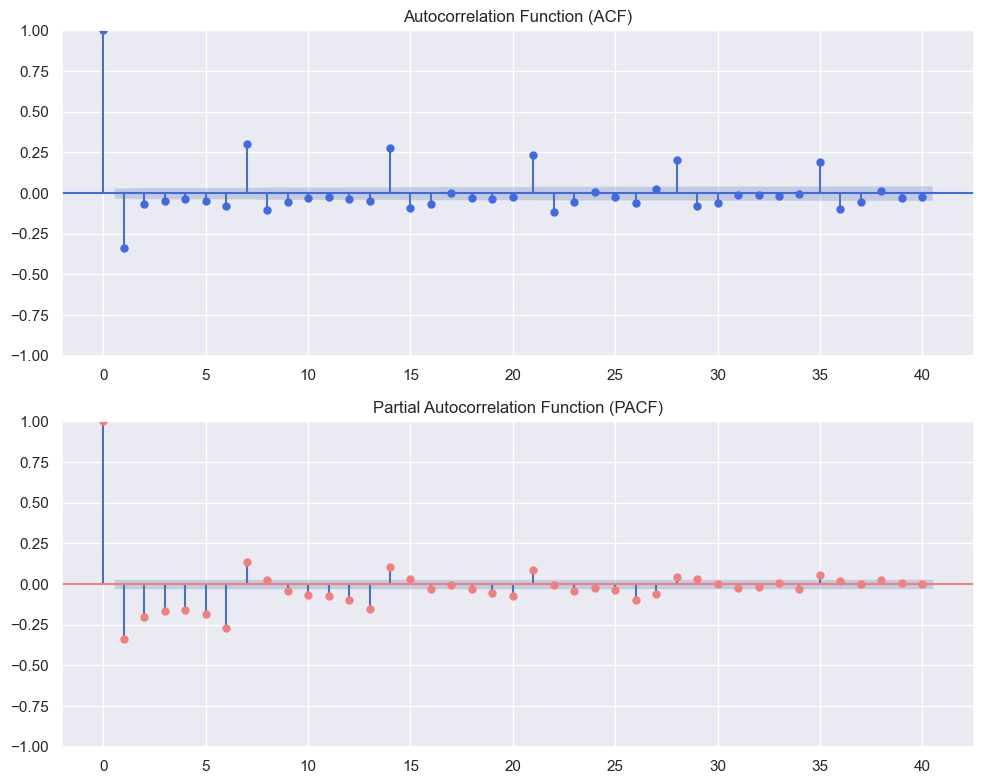

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
sgt.plot_acf(df3['diff'].dropna(), ax=ax1, lags=40,color='royalblue')
ax1.set_title('Autocorrelation Function (ACF)')
sgt.plot_pacf(df3['diff'].dropna(), ax=ax2, lags=40, color='lightcoral')
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [114]:
X = df2.drop(['Max.Demand Met during the day(MW)'], axis = 1)
y= df2[['Max.Demand Met during the day(MW)']]
X

,Energy Met (MU),Temp,Humidity,Precipitation,Wind Speed,Pressure,weekday,month,year
date,,,,,,,,,
2013-03-31,56.0,28.61,15.62,0.03,2.39,96.74,6,3,2013
2013-04-01,57.6,28.62,15.87,0.00,2.42,96.83,0,4,2013
2013-04-02,59.5,28.59,15.50,0.04,2.64,96.84,1,4,2013
2013-04-03,62.0,28.90,16.24,0.06,2.23,96.81,2,4,2013
2013-04-04,61.4,28.81,15.93,0.03,3.11,96.78,3,4,2013
...,...,...,...,...,...,...,...,...,...
2023-03-27,89.4,28.60,14.83,0.34,1.64,96.80,0,3,2023
2023-03-28,91.8,29.45,14.77,0.76,1.91,96.77,1,3,2023
2023-03-29,93.1,26.10,17.27,8.48,1.87,96.93,2,3,2023


In [115]:
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(X)
X_scaled

array([[0.31549815, 0.73483366, 0.65732759, ..., 1.        , 0.18181818,
        0.        ],
       [0.34501845, 0.73581213, 0.67528736, ..., 0.        , 0.27272727,
        0.        ],
       [0.3800738 , 0.73287671, 0.6487069 , ..., 0.16666667, 0.27272727,
        0.        ],
       ...,
       [1.        , 0.48923679, 0.77586207, ..., 0.33333333, 0.18181818,
        1.        ],
       [0.96125461, 0.62035225, 0.70617816, ..., 0.5       , 0.18181818,
        1.        ],
       [0.95387454, 0.68982387, 0.65301724, ..., 0.66666667, 0.18181818,
        1.        ]])

In [116]:
pca=PCA(0.95)
X_pca=pca.fit_transform(X_scaled)
X_pca

array([[ 0.02292604,  0.5667067 ,  0.58739049,  0.10783418, -0.16881931,
         0.0660174 ],
       [ 0.08712735, -0.43355034,  0.63925601,  0.0662685 , -0.16786314,
         0.07491905],
       [ 0.07769723, -0.27029218,  0.62052335,  0.06242077, -0.14748197,
         0.12740412],
       ...,
       [ 0.63040106, -0.14337868, -0.40909532,  0.07515973, -0.08065291,
        -0.04285287],
       [ 0.65167488,  0.03242279, -0.3891937 ,  0.06698254, -0.15076488,
         0.0398267 ],
       [ 0.6579242 ,  0.2026411 , -0.38474846,  0.06754071, -0.17118267,
         0.12419899]])

In [117]:
train_cutoff = int(0.8*X_pca.shape[0])
val_cutoff   = int(0.9*X_pca.shape[0])

In [118]:
y_scaled=scaler.fit(y[:train_cutoff])
y_norm=scaler.transform(y)
y_norm

array([[0.27754915],
       [0.37082762],
       [0.42798354],
       ...,
       [1.04526749],
       [0.99862826],
       [1.02011888]])

In [119]:
hist_size= 24
horizon=1
data_norm = np.concatenate((X_pca,y_norm), axis = 1)
data_norm

array([[ 0.02292604,  0.5667067 ,  0.58739049, ..., -0.16881931,
         0.0660174 ,  0.27754915],
       [ 0.08712735, -0.43355034,  0.63925601, ..., -0.16786314,
         0.07491905,  0.37082762],
       [ 0.07769723, -0.27029218,  0.62052335, ..., -0.14748197,
         0.12740412,  0.42798354],
       ...,
       [ 0.63040106, -0.14337868, -0.40909532, ..., -0.08065291,
        -0.04285287,  1.04526749],
       [ 0.65167488,  0.03242279, -0.3891937 , ..., -0.15076488,
         0.0398267 ,  0.99862826],
       [ 0.6579242 ,  0.2026411 , -0.38474846, ..., -0.17118267,
         0.12419899,  1.02011888]])

In [121]:
data_norm.shape

(3539, 7)

In [48]:
def windowing(X_input,y_input, history_size,horizon):

    data = []
    labels = []
    for i in range(history_size, len(y_input)):
        data.append(X_input[i - history_size : i, :])
        labels.append(y_input[i:i+horizon])

    return np.array(data), np.array(labels).reshape(-1,1)

In [49]:
X_train, y_train = windowing(data_norm[:train_cutoff,:],data_norm[:train_cutoff,-1], hist_size,horizon)
X_val, y_val     = windowing(data_norm[train_cutoff :val_cutoff,:],data_norm[train_cutoff:val_cutoff,-1], hist_size,horizon)
X_test, y_test   = windowing(data_norm[val_cutoff :,:],data_norm[val_cutoff:,-1], hist_size,horizon)

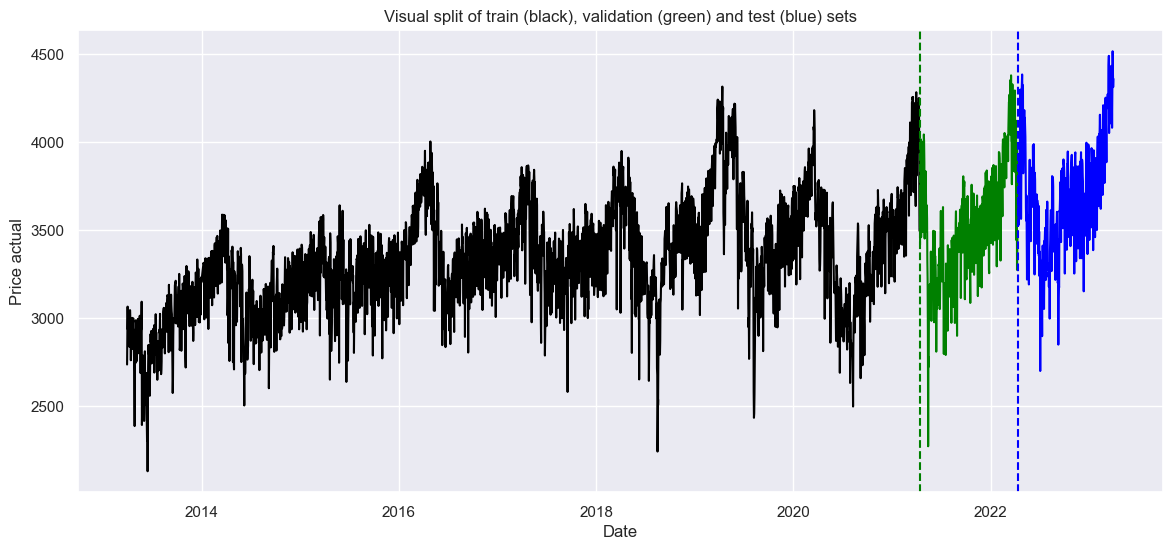

In [50]:
fig, axes = plt.subplots(figsize = (14,6))
axes.plot(df3['Max.Demand Met during the day(MW)'].iloc[:train_cutoff], color = 'black')
axes.plot(df3['Max.Demand Met during the day(MW)'].iloc[train_cutoff + 1 : val_cutoff], color = 'green')
axes.plot(df3['Max.Demand Met during the day(MW)'].iloc[val_cutoff + 1 :], color = 'blue')
axes.axvline(x=df3.index[train_cutoff], color='green', linestyle='--')
axes.axvline(x=df3.index[val_cutoff], color='blue', linestyle='--')
axes.set_title('Visual split of train (black), validation (green) and test (blue) sets')
axes.set_xlabel('Date')
axes.set_ylabel('Price actual')
plt.show()

In [51]:
epoch = 100
batch_size = 64
steps_per_epoch = len(X_train) // batch_size
cyclic_lr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-04,
                                                maximal_learning_rate=1e-02,
                                                scale_fn=lambda x: 1/(2**(x-1)),
                                                step_size=6 * steps_per_epoch)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
optimizer = Adam(learning_rate=cyclic_lr, amsgrad=True)

In [52]:
def plot_results(y_pred_actual, y_test_inv, model, model_name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    
    ax[0].plot(y_pred_actual[:1000])
    ax[0].plot(y_test_inv[:1000])
    ax[0].legend(['prediction', 'actual'], loc='upper left')
    ax[0].set_title(f'Prediction vs actual price for 1000 observation in test set ({model_name})')
    ax[0].set_xlabel('Observation')
    ax[0].set_ylabel('Price')
    
    if model != 'hybrid':
    
        if model_name == 'XGBoost':

            train_mae = model.evals_result()['validation_0']['mae']
            val_mae = model.evals_result()['validation_1']['mae']
            ax[1].plot(train_mae, label='Training MAE')
            ax[1].plot(val_mae, label='Validation MAE')

        else:

            ax[1].plot(history.history['loss'], label='Training Loss')
            ax[1].plot(history.history['val_loss'], label='Validation Loss')

        ax[1].legend()
        ax[1].set_title(f'Training and validation MAE ({model_name})')
        ax[1].set_xlabel('Iteration/Epochs')
        ax[1].set_ylabel('MAE')    
        
    fig.tight_layout()
    plt.show()
    

In [53]:
def evaluate_pred(true_values, predicted_values):
    mae = round(mean_absolute_error(true_values, predicted_values), 3)
    mse = round(mean_squared_error(true_values, predicted_values), 3)
    rmse = round(np.sqrt(mse), 3)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)

In [54]:
def reshaping(X):

    reshaped_x = X.reshape(-1 , X.shape[1] * X.shape[2])
    return reshaped_x

SARIMAX

In [ ]:
X_train_sr = reshaping(X_train)
X_val_sr = reshaping(X_val)
X_test_sr  = reshaping(X_test)
y_test_inv=scaler.inverse_transform(y_test)

sarimax_model = sts.tsa.statespace.SARIMAX(endog=y_train, exog=X_train_sr, order=(1,1,1), seasonal_order=(1,1,1,12))
sarimax_result = sarimax_model.fit()

preds = sarimax_result.predict(start=0, end=len(X_test_sr)-1,exog=X_test_sr, dynamic=True)

evaluate_pred(y_test,preds)

D:\Users\aneeta\anaconda3\envs\tensorflowgpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
D:\Users\aneeta\anaconda3\envs\tensorflowgpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [ ]:
y_pred_actual = scaler.inverse_transform(preds.reshape(-1,1))
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(y_pred_actual[:1000])
ax[0].plot(y_test_inv[:1000])
ax[0].legend(['prediction', 'actual'], loc='upper left')
ax[0].set_xlabel('Observation')
ax[0].set_ylabel('Demand')

Random Forest

In [123]:
X_train_rfr = reshaping(X_train)
X_val_rfr = reshaping(X_val)
X_test_rfr  = reshaping(X_test)

In [124]:
from sklearn.ensemble import RandomForestRegressor
# Initialize the Random Forest Regressor with desired hyperparameters
rfr = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training dataset
rfr.fit(X_train_rfr, y_train.ravel())

# Predict on the test dataset
y_test_pred = rfr.predict(X_test_rfr)

In [125]:
evaluate_pred(y_test, y_test_pred)

Mean Absolute Error (MAE): 0.059
Mean Squared Error (MSE): 0.006
Root Mean Squared Error (RMSE): 0.077


In [126]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def plot_result(y_pred_actual, y_test_inv, model, model_name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))

    ax[0].plot(y_pred_actual[:1000], label='Prediction')
    ax[0].plot(y_test_inv[:1000], label='Actual')
    ax[0].legend(loc='upper left')
    ax[0].set_title(f'Prediction vs actual price for 1000 observation in test set ({model_name})')
    ax[0].set_xlabel('Observation')
    ax[0].set_ylabel('Price')

    if model_name == 'RandomForest':
        y_train_pred = model.predict(X_train_rfr)  # Assuming X_train_rfr is your training data
        train_mae = mean_absolute_error(y_train, y_train_pred)
        y_val_pred = model.predict(X_val_rfr)  # Assuming X_val_rfr is your validation data
        val_mae = mean_absolute_error(y_val, y_val_pred)

        ax[1].plot([train_mae], label='Training MAE')
        ax[1].plot([val_mae], label='Validation MAE')
        ax[1].legend(loc='upper left')
        ax[1].set_title(f'Training and validation MAE ({model_name})')
        ax[1].set_xlabel('Iteration/Epochs')
        ax[1].set_ylabel('MAE')
    

    fig.tight_layout()
    plt.show()


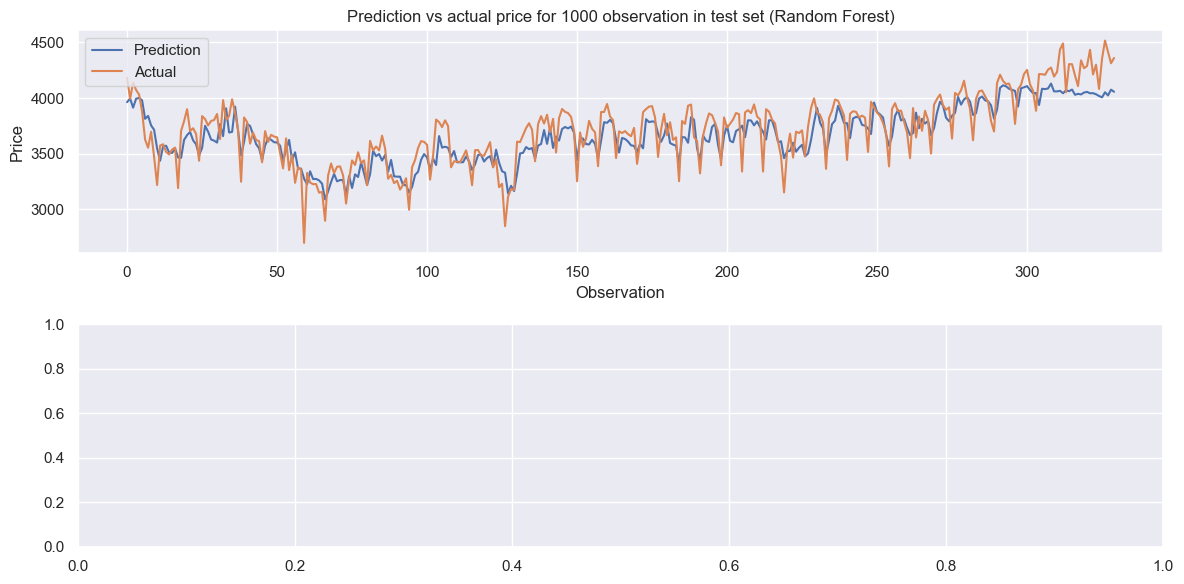

In [127]:
y_pred_actual = scaler.inverse_transform(y_test_pred.reshape(-1,1))
y_test_pred_inv = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
plot_result(y_test_pred_inv, y_test_inv, rfr, 'Random Forest')

XGBOOST

In [55]:
X_train_xgb = reshaping(X_train)
X_val_xgb   = reshaping(X_val)
X_test_xgb  = reshaping(X_test)

D:\Users\aneeta\anaconda3\envs\tensorflowgpu\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
D:\Users\aneeta\anaconda3\envs\tensorflowgpu\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoost MAE for test set : 0.072


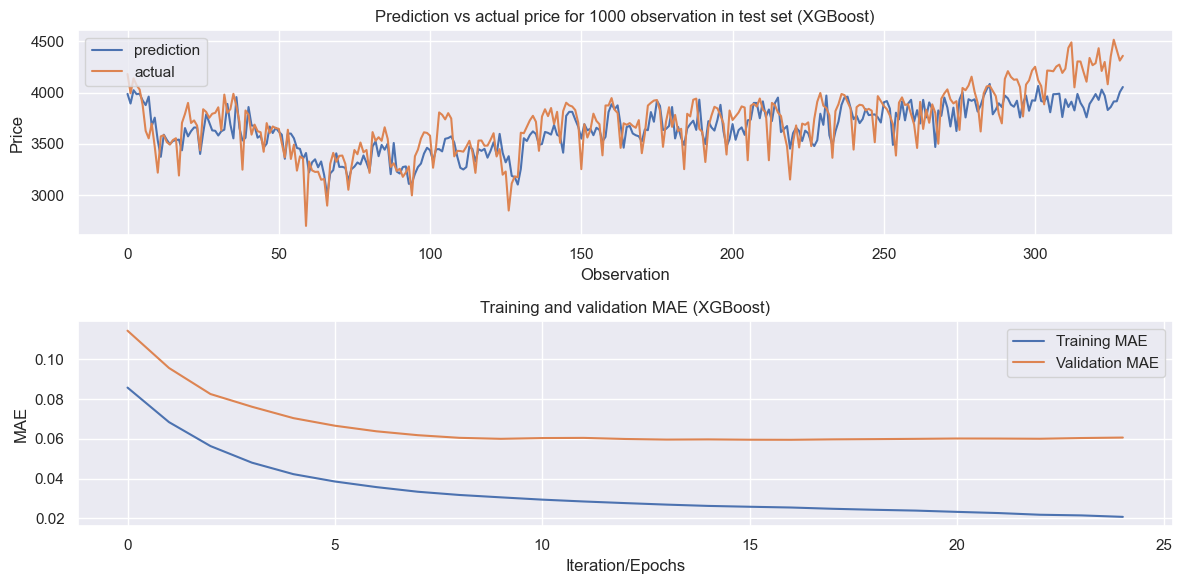

In [56]:
xgb_model = xgb.XGBRegressor()

xgb_model.fit(X_train_xgb, y_train,
               eval_set=[(X_train_xgb, y_train), (X_val_xgb, y_val)],
               eval_metric='mae',
               early_stopping_rounds=8,
               verbose=False)
y_pred = xgb_model.predict(X_test_xgb)
y_pred_actual = y_scaled.inverse_transform(y_pred.reshape(-1,1))
y_test_inv = y_scaled.inverse_transform(y_test)
print(f'XGBoost MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
plot_results(y_pred_actual, y_test_inv, xgb_model,'XGBoost')

CNN

Epoch 1/50
44/44 [==============================] - 12s 24ms/step - loss: 0.1271 - val_loss: 0.0759
Epoch 2/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0746 - val_loss: 0.0763
Epoch 3/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0703 - val_loss: 0.0708
Epoch 4/50
44/44 [==============================] - 1s 13ms/step - loss: 0.0670 - val_loss: 0.0703
Epoch 5/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0648 - val_loss: 0.0695
Epoch 6/50
44/44 [==============================] - 1s 13ms/step - loss: 0.0626 - val_loss: 0.0709
Epoch 7/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0635 - val_loss: 0.0669
Epoch 8/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0612 - val_loss: 0.0622
Epoch 9/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0605 - val_loss: 0.0687
Epoch 10/50
44/44 [==============================] - 1s 13ms/step - loss: 0.0598 - val_loss: 0.0661
Epoch 11

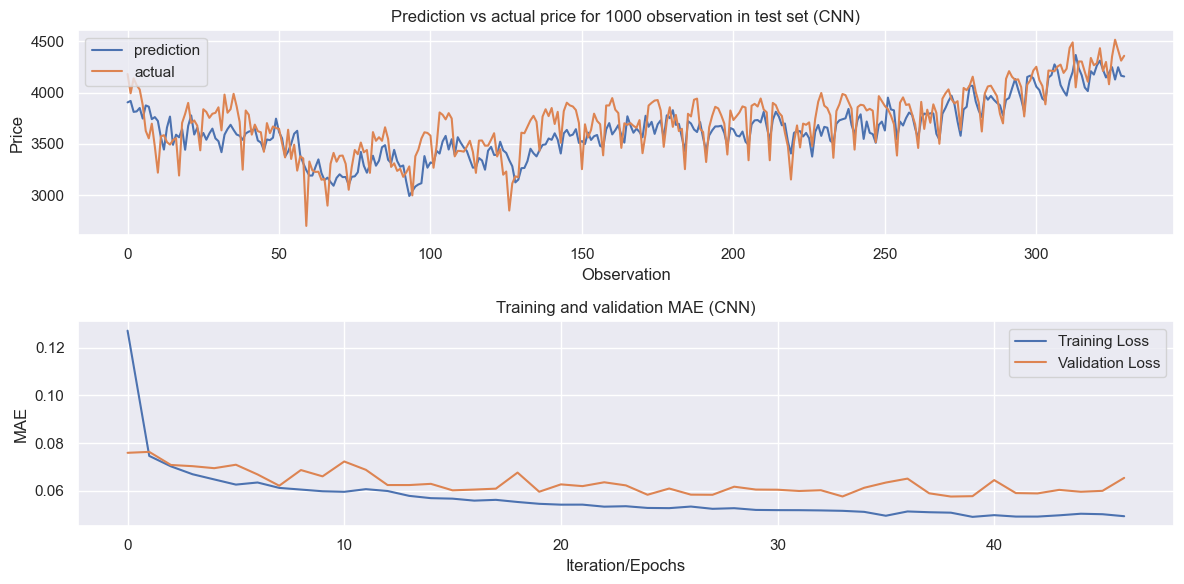

In [128]:
def base_model_cnn():
    
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(horizon))
    
    return model

cnn_model = base_model_cnn()
cnn_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')

history = cnn_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 50, 
                   batch_size = batch_size, callbacks=[callback])

y_test_inv=scaler.inverse_transform(y_test)
y_pred = cnn_model.predict(X_test)
print(f'CNN MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
y_pred_actual = scaler.inverse_transform(y_pred)
plot_results(y_pred_actual, y_test_inv, history,'CNN')

In [129]:
cnn_results = evaluate_pred(y_test, # reduce to right shape
                                 y_pred)
cnn_results

Mean Absolute Error (MAE): 0.072
Mean Squared Error (MSE): 0.007
Root Mean Squared Error (RMSE): 0.084


LSTM

In [130]:
def base_model_lstm():

    model = Sequential()
    model.add(LSTM(units = 32, return_sequences = True, activation="relu", input_shape = X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    
    return model

lstm_model = base_model_lstm()
lstm_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
lstm_model.summary()

history = lstm_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs =epoch, 
                   batch_size = batch_size, callbacks=[callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24, 32)            5120      
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               98432     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 103,681
Trainable params: 103,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
44/44 [=============================

11/11 [==============================] - 1s 22ms/step
LSTM MAE for test set : 0.063


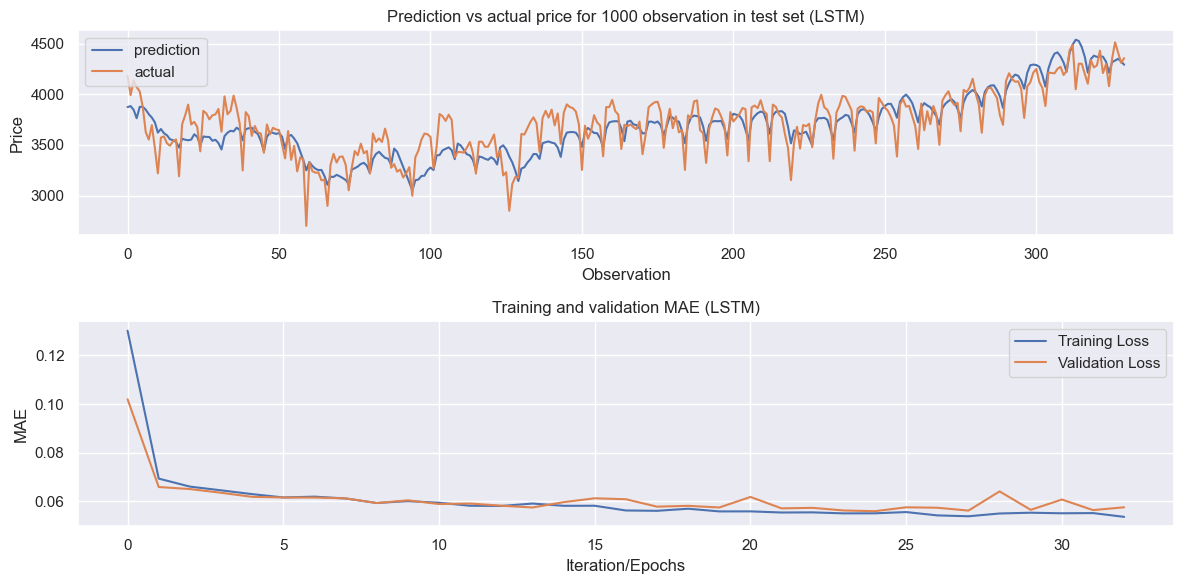

In [131]:
y_pred = lstm_model.predict(X_test)
print(f'LSTM MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
y_pred_actual = scaler.inverse_transform(y_pred)
plot_results(y_pred_actual, y_test_inv, history,'LSTM')

CNN-LSTM

In [132]:
def base_model_cnn_lstm():
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X_train.shape[-2:]))
    model.add(LSTM(units = 8, return_sequences = True, activation="relu"))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1))
    
    return model

cnn_lstm_model = base_model_cnn_lstm()
cnn_lstm_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
cnn_lstm_model.summary()

history = cnn_lstm_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 22, 64)            1408      
                                                                 
 lstm_2 (LSTM)               (None, 22, 8)             2336      
                                                                 
 flatten_3 (Flatten)         (None, 176)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               45312     
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 49,313
Trainable params: 49,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
44/44 [==============================]

11/11 [==============================] - 1s 19ms/step
CNN-LSTM MAE for test set : 0.064


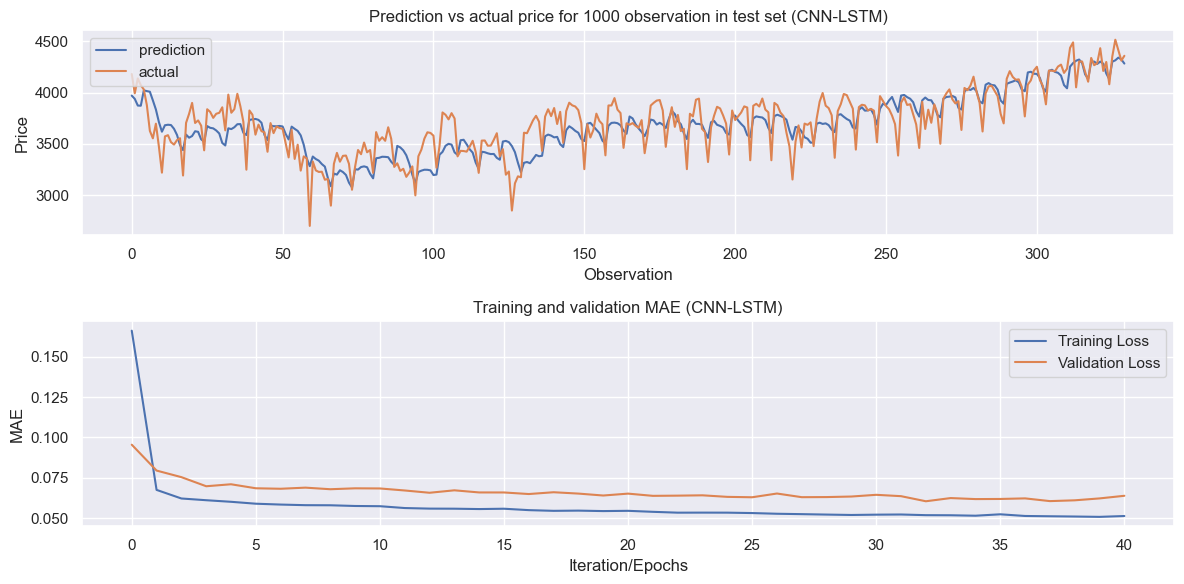

In [133]:
y_pred = cnn_lstm_model.predict(X_test)
print(f'CNN-LSTM MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
y_pred_actual = scaler.inverse_transform(y_pred)
plot_results(y_pred_actual, y_test_inv, history,'CNN-LSTM')

GRU

Epoch 1/100
44/44 [==============================] - 13s 205ms/step - loss: 0.1216 - val_loss: 0.0848
Epoch 2/100
44/44 [==============================] - 8s 192ms/step - loss: 0.0709 - val_loss: 0.0722
Epoch 3/100
44/44 [==============================] - 8s 186ms/step - loss: 0.0683 - val_loss: 0.0647
Epoch 4/100
44/44 [==============================] - 8s 190ms/step - loss: 0.0645 - val_loss: 0.0627
Epoch 5/100
44/44 [==============================] - 8s 184ms/step - loss: 0.0636 - val_loss: 0.0653
Epoch 6/100
44/44 [==============================] - 8s 182ms/step - loss: 0.0614 - val_loss: 0.0676
Epoch 7/100
44/44 [==============================] - 8s 186ms/step - loss: 0.0610 - val_loss: 0.0625
Epoch 8/100
44/44 [==============================] - 8s 184ms/step - loss: 0.0603 - val_loss: 0.0653
Epoch 9/100
44/44 [==============================] - 8s 185ms/step - loss: 0.0579 - val_loss: 0.0595
Epoch 10/100
44/44 [==============================] - 8s 190ms/step - loss: 0.0576 - val_l

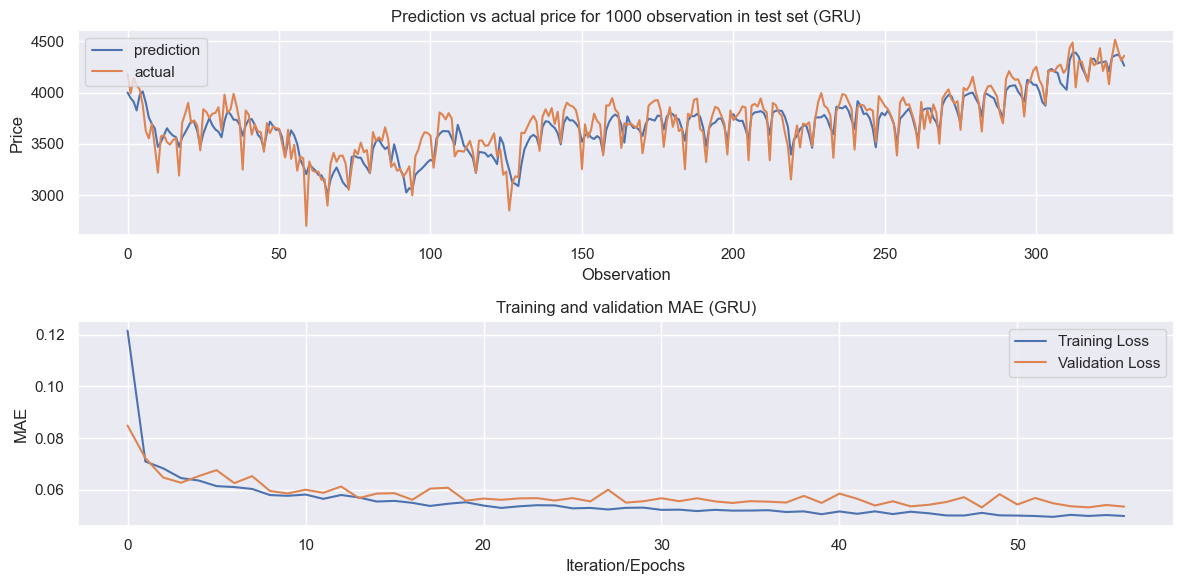

In [134]:
def base_model_gru():

    model = Sequential()
    model.add(GRU(units=32, return_sequences=True, activation="relu", input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    return model

gru_model = base_model_gru()

gru_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
history = gru_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch,
                   batch_size = batch_size, callbacks=[callback])

y_pred = gru_model.predict(X_test)
print(f'GRU MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
y_pred_actual = y_scaled.inverse_transform(y_pred)
plot_results(y_pred_actual, y_test_inv, history,'GRU')

GRU - XGBOOST

In [135]:
def base_model_gru():
    model = Sequential()
    model.add(GRU(units=32, return_sequences=True, activation="relu", input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    return model

# Create and compile the GRU model
gru_model = base_model_gru()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust learning rate as needed

gru_model.compile(optimizer=optimizer, loss='mean_absolute_error')
print('GRU is fitting a model on train-validation sets...')
print('')

# Assuming X_train, y_train, X_val, y_val, epoch, and batch_size are defined
gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoch,
              batch_size=batch_size, callbacks=[callback])

print('')
print('----------------------------------')
print('GRU is predicting...')
print('')

# Assuming X_train_xgb, X_val_xgb, residuals_train, residuals_val are defined
residuals_train = y_train - gru_model.predict(X_train)
residuals_val = y_val - gru_model.predict(X_val)

print('')
print('----------------------------------')
print('XGBoost is fitting a model on residuals...')
print('')

# Instantiate XGBRegressor with desired parameters including eval_metric and early_stopping_rounds
xgb_hybrid = xgb.XGBRegressor(eval_metric='mae', early_stopping_rounds=8)

# Fit the model using fit method (without passing eval_metric and early_stopping_rounds)
xgb_hybrid.fit(X_train_xgb, residuals_train,
               eval_set=[(X_train_xgb, residuals_train), (X_val_xgb, residuals_val)],
               verbose=False)

# Combine predictions from GRU model and XGBoost model
y_train_pred = gru_model.predict(X_train) + xgb_hybrid.predict(X_train_xgb).reshape(-1, 1)
y_val_pred = gru_model.predict(X_val) + xgb_hybrid.predict(X_val_xgb).reshape(-1, 1)


GRU is fitting a model on train-validation sets...

Epoch 1/100
44/44 [==============================] - 13s 206ms/step - loss: 0.1096 - val_loss: 0.0658
Epoch 2/100
44/44 [==============================] - 8s 187ms/step - loss: 0.0708 - val_loss: 0.0651
Epoch 3/100
44/44 [==============================] - 8s 186ms/step - loss: 0.0660 - val_loss: 0.0780
Epoch 4/100
44/44 [==============================] - 8s 187ms/step - loss: 0.0635 - val_loss: 0.0668
Epoch 5/100
44/44 [==============================] - 8s 188ms/step - loss: 0.0611 - val_loss: 0.0594
Epoch 6/100
44/44 [==============================] - 8s 192ms/step - loss: 0.0601 - val_loss: 0.0582
Epoch 7/100
44/44 [==============================] - 8s 188ms/step - loss: 0.0593 - val_loss: 0.0581
Epoch 8/100
44/44 [==============================] - 9s 193ms/step - loss: 0.0576 - val_loss: 0.0546
Epoch 9/100
44/44 [==============================] - 8s 187ms/step - loss: 0.0559 - val_loss: 0.0623
Epoch 10/100
44/44 [==================

11/11 [==============================] - 0s 25ms/step
GRU-XGBoost MAE for test set : 0.05


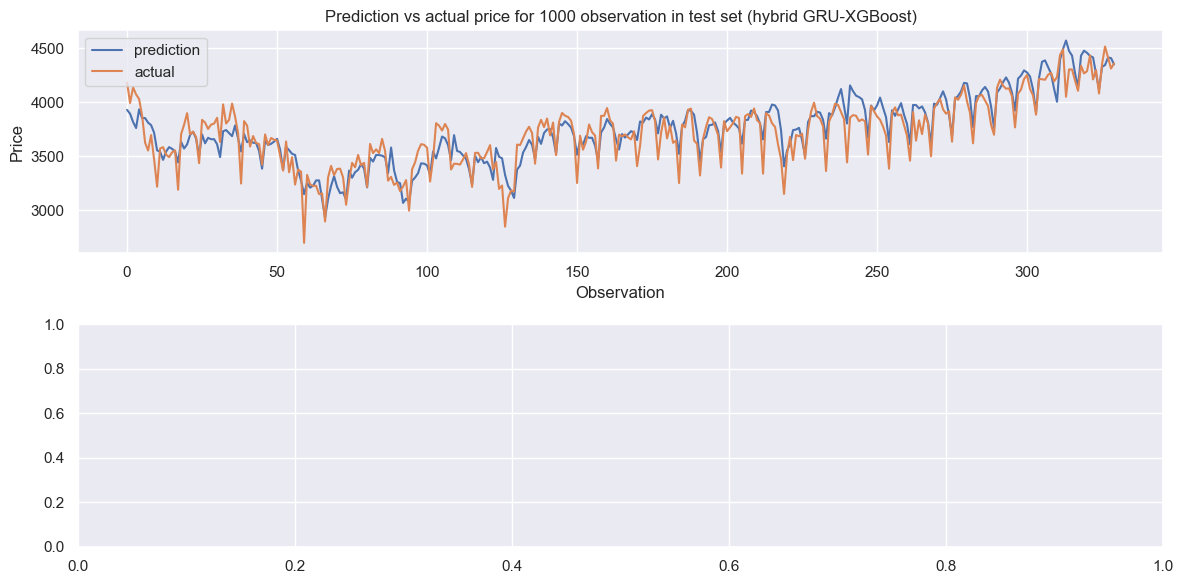

In [136]:
y_test_pred  = gru_model.predict(X_test) + xgb_hybrid.predict(X_test_xgb).reshape(-1,1)
print(f'GRU-XGBoost MAE for test set : {round(mean_absolute_error(y_test_pred,y_test),3)}')
y_pred_actual = y_scaled.inverse_transform(y_test_pred)
plot_results(y_pred_actual, y_test_inv, 'hybrid' ,'hybrid GRU-XGBoost')

LSTM ATTENTION XGBOOST

In [137]:
def LSTM_attention(hist_size, input_shape):
    inputs = Input(shape=(hist_size, input_shape))
    masked = Masking(mask_value=0.)(inputs)
    lstm = LSTM(132, return_sequences=True)(masked)
    attention = dot([lstm, lstm], axes=[2, 2])
    attention = Dense(hist_size, activation='softmax')(attention)
    context = dot([attention, lstm], axes=[2, 1])
    flattened = Flatten()(context)
    output = Dense(1)(flattened)
    model = Model(inputs=inputs, outputs=output)
    return model

# Assuming X_train, y_train, X_val, y_val, X_train_xgb, X_val_xgb, residuals_train, residuals_val are defined

hist_size = X_train.shape[1]  # Assuming hist_size is the length of the historical sequence
input_shape = X_train.shape[2]  # Assuming input_shape is the number of features in each time step

# Create and compile LSTM with Attention model
LSTM_attention_model = LSTM_attention(hist_size, input_shape)
LSTM_attention_model.compile(optimizer=optimizer, loss='mae')


print('')
print('LSTM-Attention is fitting a model on train-validation sets...')
print('')

# Fit LSTM with Attention model
LSTM_attention_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoch,
                          batch_size=batch_size, callbacks=[callback])

print('')
print('----------------------------------')
print('LSTM-attention is predicting...')
print('')

# Predict residuals
residuals_train = y_train - LSTM_attention_model.predict(X_train)
residuals_val = y_val - LSTM_attention_model.predict(X_val)

print('')
print('----------------------------------')
print('XGBoost is fitting a model on residuals...')
print('')

# Train XGBoost regressor on residuals
xgb_hybrid = xgb.XGBRegressor(eval_metric='mae', early_stopping_rounds=8)
xgb_hybrid.fit(X_train_xgb, residuals_train,
               eval_set=[(X_train_xgb, residuals_train), (X_val_xgb, residuals_val)],
               verbose=False)


# Combine predictions from LSTM with Attention model and XGBoost model
y_train_pred = LSTM_attention_model.predict(X_train) + xgb_hybrid.predict(X_train_xgb).reshape(-1, 1)
y_val_pred = LSTM_attention_model.predict(X_val) + xgb_hybrid.predict(X_val_xgb).reshape(-1, 1)


LSTM-Attention is fitting a model on train-validation sets...

Epoch 1/100
44/44 [==============================] - 15s 116ms/step - loss: 0.1104 - val_loss: 0.0975
Epoch 2/100
44/44 [==============================] - 2s 35ms/step - loss: 0.0686 - val_loss: 0.0746
Epoch 3/100
44/44 [==============================] - 1s 34ms/step - loss: 0.0658 - val_loss: 0.0801
Epoch 4/100
44/44 [==============================] - 2s 34ms/step - loss: 0.0647 - val_loss: 0.0750
Epoch 5/100
44/44 [==============================] - 1s 34ms/step - loss: 0.0643 - val_loss: 0.0690
Epoch 6/100
44/44 [==============================] - 2s 35ms/step - loss: 0.0606 - val_loss: 0.0678
Epoch 7/100
44/44 [==============================] - 1s 34ms/step - loss: 0.0587 - val_loss: 0.0648
Epoch 8/100
44/44 [==============================] - 2s 35ms/step - loss: 0.0586 - val_loss: 0.0645
Epoch 9/100
44/44 [==============================] - 2s 35ms/step - loss: 0.0579 - val_loss: 0.0631
Epoch 10/100
44/44 [==============

11/11 [==============================] - 0s 13ms/step


---------------------------------------------------
LSTM-Attention-XGBoost MAE for test set : 0.048
---------------------------------------------------



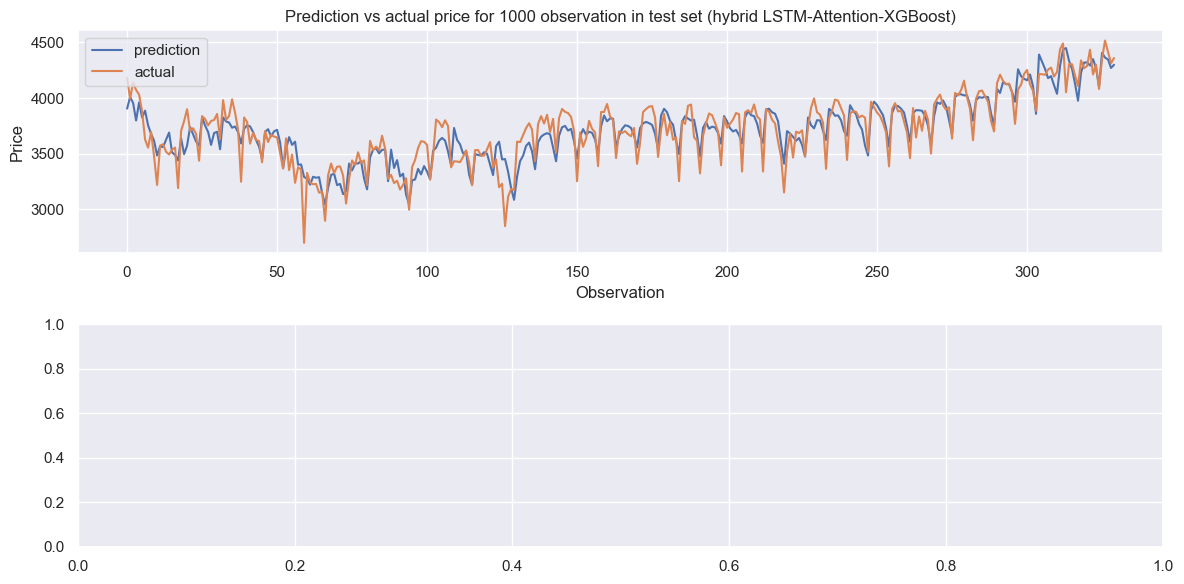

In [138]:
y_test_pred  = LSTM_attention_model.predict(X_test) + xgb_hybrid.predict(X_test_xgb).reshape(-1,1)
print('')
print('')

print('---------------------------------------------------')
print(f'LSTM-Attention-XGBoost MAE for test set : {round(mean_absolute_error(y_test_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = y_scaled.inverse_transform(y_test_pred)
print('')
plot_results(y_pred_actual, y_test_inv, 'hybrid' ,'hybrid LSTM-Attention-XGBoost')

In [139]:
y_future  = LSTM_attention_model.predict(X_test)+ xgb_hybrid.predict(X_test_xgb).reshape(-1,1)
y_future_actual = y_scaled.inverse_transform(y_future)
y_future_actual[:30]

11/11 [==============================] - 0s 14ms/step


array([[3905.0789],
       [4010.0928],
       [3956.3313],
       [3798.6208],
       [3961.6772],
       [3825.9592],
       [3886.76  ],
       [3754.6838],
       [3677.2656],
       [3616.057 ],
       [3484.0295],
       [3568.6   ],
       [3559.8494],
       [3626.82  ],
       [3690.0295],
       [3511.5999],
       [3488.313 ],
       [3439.7314],
       [3637.8425],
       [3495.8787],
       [3573.2195],
       [3740.361 ],
       [3675.4597],
       [3608.619 ],
       [3571.4683],
       [3825.171 ],
       [3753.069 ],
       [3695.6306],
       [3579.3958],
       [3685.952 ]], dtype=float32)